## PixelsPatchwork Data Analytics

## Database Connection

In [ ]:
!pip install pymysql

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.0 MB/s eta 0:00:00


In [ ]:
# Imports
import os
import duckdb
import pymysql
import pandas as pd
from getpass import getpass
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Enter credentials through getpass and store as env
print('Enter MySQL credentials:')
os.environ['DB_USER'] = input('Username: ')
os.environ['DB_PASSWORD'] = getpass('Password: ')
os.environ['DB_HOST'] = input('Host: ')
os.environ['DB_NAME'] = input('Database name: ')
os.environ['DB_PORT'] = input('Port (default 3306): ') or '3306'

Enter MySQL credentials:
Username: admin
Password: ··········
Host: pixelspatchwork-db.ctwqm8aymij2.us-east-1.rds.amazonaws.com
Database name: pixelspatchwork
Port (default 3306): 3306


In [ ]:
# Create MySQL connection
connection_string = f"mysql+pymysql://{os.environ['DB_USER']}:{os.environ['DB_PASSWORD']}@{os.environ['DB_HOST']}:{os.environ['DB_PORT']}/{os.environ['DB_NAME']}"
mysql_engine = create_engine(connection_string)

# Create DuckDB connection
duck_conn = duckdb.connect(':memory:')

# Show available tables
with mysql_engine.connect() as conn:
    tables = pd.read_sql("SHOW TABLES", conn)
    print("\nAvailable tables:")
    print(tables)


Available tables:
  Tables_in_pixelspatchwork
0                       Day
1                     Image
2                      User
3         UserDailyActivity


In [ ]:
# Load tables
tables = ['User', 'Image', 'Day']
for table in tables:
    # Load from MySQL to pandas
    df = pd.read_sql(f"SELECT * FROM {table}", mysql_engine)

    # Save to CSV for reference
    csv_filename = f"{table.lower()}_data.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Exported {table} to {csv_filename}")

    # Load into DuckDB
    duck_conn.register(table, df)
    print(f"Loaded {table} into DuckDB")
    print(f"Table shape: {df.shape}\n")

Exported User to user_data.csv
Loaded User into DuckDB
Table shape: (185, 4)

Exported Image to image_data.csv
Loaded Image into DuckDB
Table shape: (226, 9)

Exported Day to day_data.csv
Loaded Day into DuckDB
Table shape: (12, 5)



## User Activity Analysis

### Overall User Engagement

In [ ]:
# Overall user engagement metrics
query1 = """
SELECT
    u.user_id,
    COUNT(i.image_id) as images_created,
    SUM(i.upvotes) as total_upvotes_received,
    SUM(i.downvotes) as total_downvotes_received,
    ROUND(AVG(i.upvotes), 2) as avg_upvotes_per_image,
    MAX(i.upvotes) as highest_upvotes_received
FROM User u
LEFT JOIN Image i ON u.user_id = i.creator_id
GROUP BY u.user_id
ORDER BY images_created DESC;
"""

result1 = duck_conn.execute(query1).fetchdf()
display(result1)

,user_id,images_created,total_upvotes_received,total_downvotes_received,avg_upvotes_per_image,highest_upvotes_received
0,092cb579-41fd-471a-a463-b4d863ce8ecf,10,2.0,4.0,0.20,1.0
1,7ce07396-b47c-4beb-a4b2-ade1c53de52d,10,2.0,6.0,0.20,1.0
2,aec41c5e-cee3-47fd-94b6-e7cd29d55574,8,1.0,4.0,0.13,1.0
3,301b6e94-234e-4485-af62-bec7618710b0,7,12.0,3.0,1.71,3.0
4,1d141039-980c-42f5-a31e-490c33d223e2,6,1.0,2.0,0.17,1.0
...,...,...,...,...,...,...
180,88670e72-2458-4ad0-81dd-a53fbd1e62ed,0,NaN,NaN,NaN,NaN
181,ba8967e7-da34-4a85-82d1-46017071d35a,0,NaN,NaN,NaN,NaN
182,a6e07726-7633-46ea-b7b3-dccae09cae56,0,NaN,NaN,NaN,NaN
183,f7818e93-b746-4150-bcf4-8e0ac7ef20e6,0,NaN,NaN,NaN,NaN


<Figure size 1200x600 with 0 Axes>

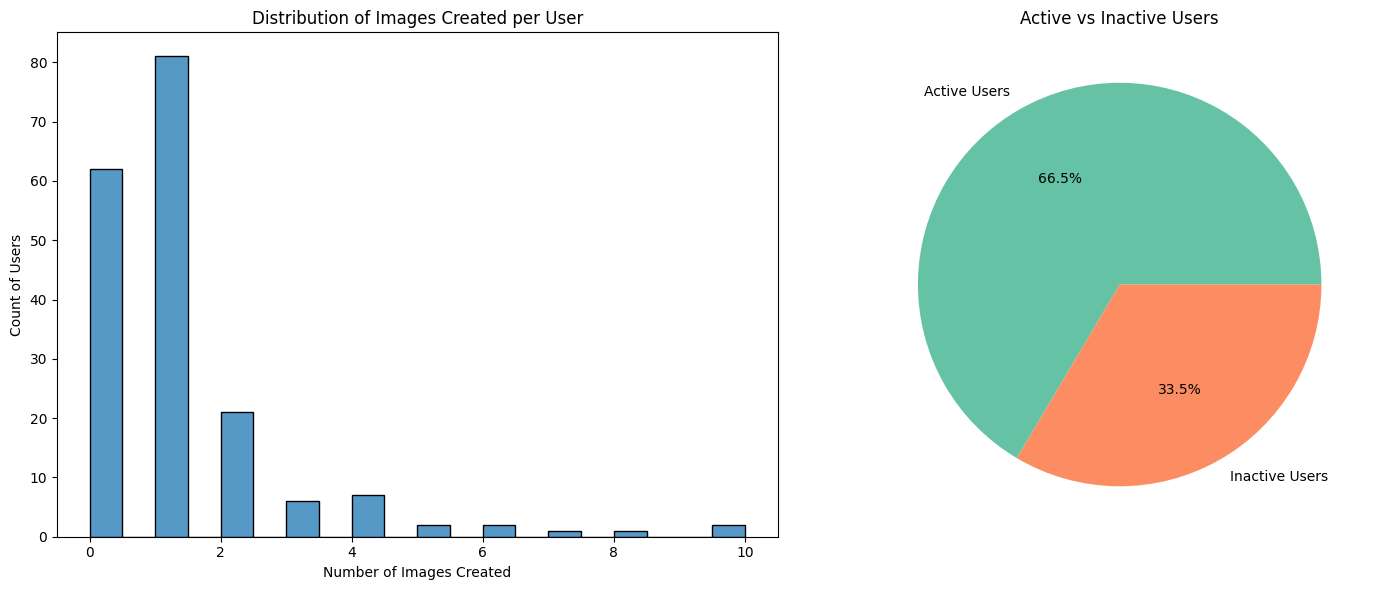

In [ ]:
# Graph only the image_id
query = """
SELECT
    u.user_id,
    COUNT(i.image_id) as images_created
FROM User u
LEFT JOIN Image i ON u.user_id = i.creator_id
GROUP BY u.user_id
"""

participation_data = duck_conn.execute(query).fetchdf()

plt.figure(figsize=(12, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Distribution of images created per user
sns.histplot(data=participation_data, x='images_created', bins=20, ax=ax1)
ax1.set_title('Distribution of Images Created per User')
ax1.set_xlabel('Number of Images Created')
ax1.set_ylabel('Count of Users')

# Plot 2: Pie chart of active vs inactive users
active_users = (participation_data['images_created'] > 0).sum()
inactive_users = (participation_data['images_created'] == 0).sum()
ax2.pie([active_users, inactive_users],
        labels=['Active Users', 'Inactive Users'],
        autopct='%1.1f%%',
        colors=sns.color_palette("Set2"))
ax2.set_title('Active vs Inactive Users')

plt.tight_layout()
plt.show()

### User Participation Patterns

<Figure size 1200x600 with 0 Axes>

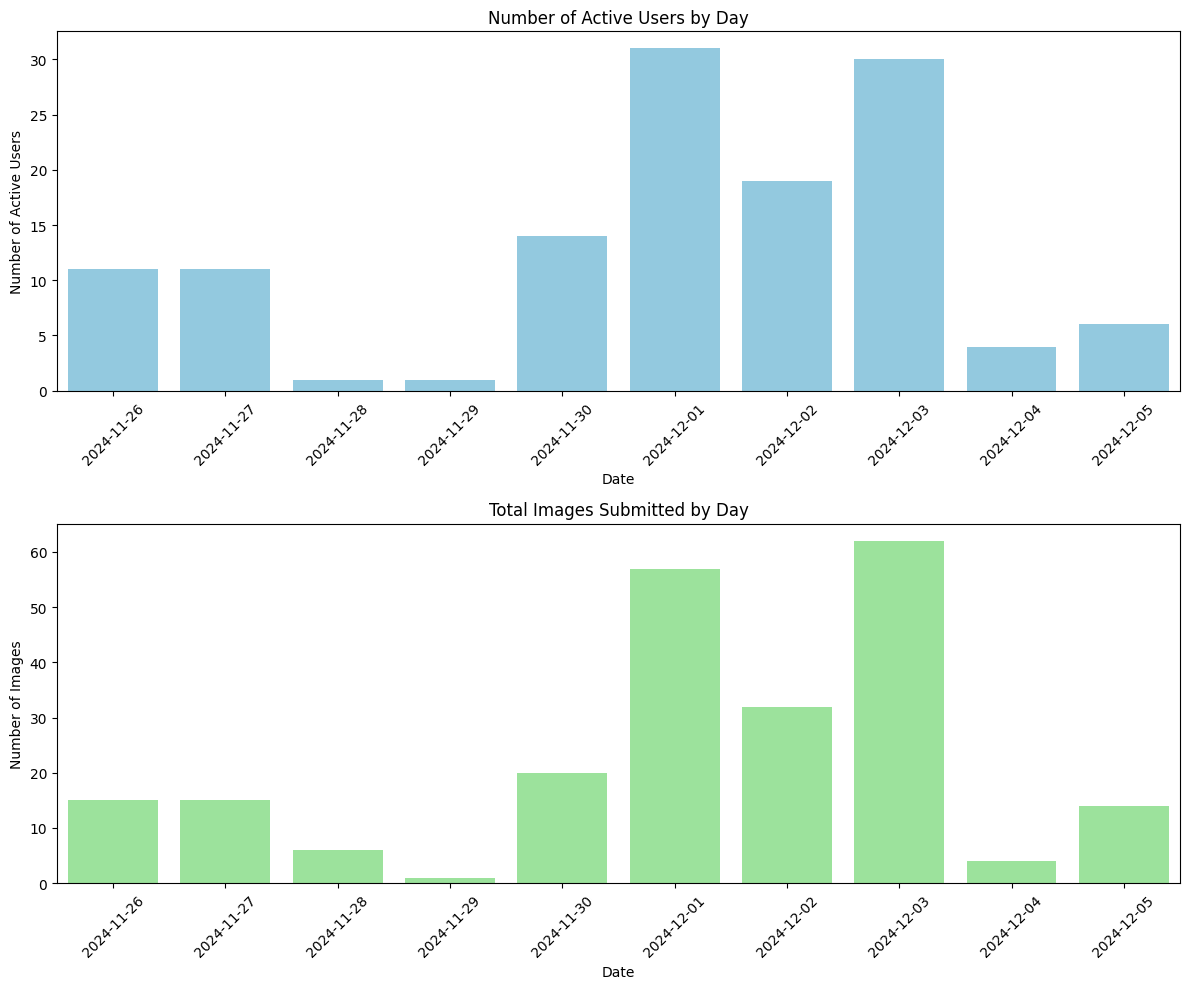

In [ ]:
query2 = """
SELECT
    i.day,
    COUNT(DISTINCT i.creator_id) as active_users,
    COUNT(i.image_id) as total_images
FROM Image i
GROUP BY i.day
ORDER BY i.day;
"""

daily_participation = duck_conn.execute(query2).fetchdf()

plt.figure(figsize=(12, 6))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Number of active users by day
sns.barplot(data=daily_participation, x='day', y='active_users', color='skyblue', ax=ax1)
ax1.set_title('Number of Active Users by Day')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Active Users')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Total images submitted by day
sns.barplot(data=daily_participation, x='day', y='total_images', color='lightgreen', ax=ax2)
ax2.set_title('Total Images Submitted by Day')
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Images')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### User Success Metrics

In [ ]:
query3 = """
SELECT
    u.user_id,
    COUNT(i.image_id) as total_images,
    SUM(CASE WHEN i.upvotes > i.downvotes THEN 1 ELSE 0 END) as positive_reception_images,
    ROUND(AVG(i.upvotes - i.downvotes), 2) as avg_net_votes,
    ROUND(SUM(CASE WHEN i.upvotes > i.downvotes THEN 1 ELSE 0 END)::FLOAT /
          NULLIF(COUNT(i.image_id), 0) * 100, 2) as success_rate_percent
FROM User u
LEFT JOIN Image i ON u.user_id = i.creator_id
GROUP BY u.user_id
HAVING total_images > 0
ORDER BY success_rate_percent DESC;
"""

result3 = duck_conn.execute(query3).fetchdf()
display(result3)

,user_id,total_images,positive_reception_images,avg_net_votes,success_rate_percent
0,7082a971-d96a-479d-b863-ea4d5ae9b4ac,1,1.0,4.0,100.0
1,7d256beb-9496-4af9-9831-df6eac3c0998,1,1.0,4.0,100.0
2,842470ec-508f-4fa9-96eb-471dd439ebce,1,1.0,1.0,100.0
3,8115328c-81bc-4975-9113-c61fbf1ce311,1,1.0,1.0,100.0
4,f92f087a-d918-492c-b0b4-eeb0d14b45ea,1,1.0,4.0,100.0
...,...,...,...,...,...
118,47d510b3-584b-4c43-b825-31fc83b9652e,1,0.0,-2.0,0.0
119,68471436-e2f8-4fef-b302-b3ec95d9c554,1,0.0,0.0,0.0
120,b30245a3-b325-4b02-b568-351d89ebb706,1,0.0,0.0,0.0
121,056fa1a0-7383-4ba6-b826-ea1b6f2131c1,1,0.0,-1.0,0.0


## Prompt Analysis

### Wordcloud for winning/all images

In [ ]:
# Imports
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import re

In [ ]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# Get aLL images with their metrics
query4 = """
SELECT
    i.image_id,
    i.prompt_text,
    i.upvotes,
    i.downvotes,
    i.flags,
    i.day,
    CASE WHEN d.seed_image_id = i.image_id THEN 1 ELSE 0 END as is_winner
FROM Image i
LEFT JOIN Day d ON d.seed_image_id = i.image_id
ORDER BY i.day;
"""

all_prompts = duck_conn.execute(query4).fetchdf()

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

# Text preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = str(text).lower()

    # Tokenization using RegexpTokenizer
    tokens = tokenizer.tokenize(text)

    # Get stopwords
    stop_words = set(stopwords.words('english'))

    # Stopwords relevant to image generation
    custom_stops = {'make', 'image', 'picture', 'photo', 'style', 'like', 'using', 'show', 'create'}
    stop_words.update(custom_stops)

    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

all_prompts['processed_text'] = all_prompts['prompt_text'].apply(preprocess_text)

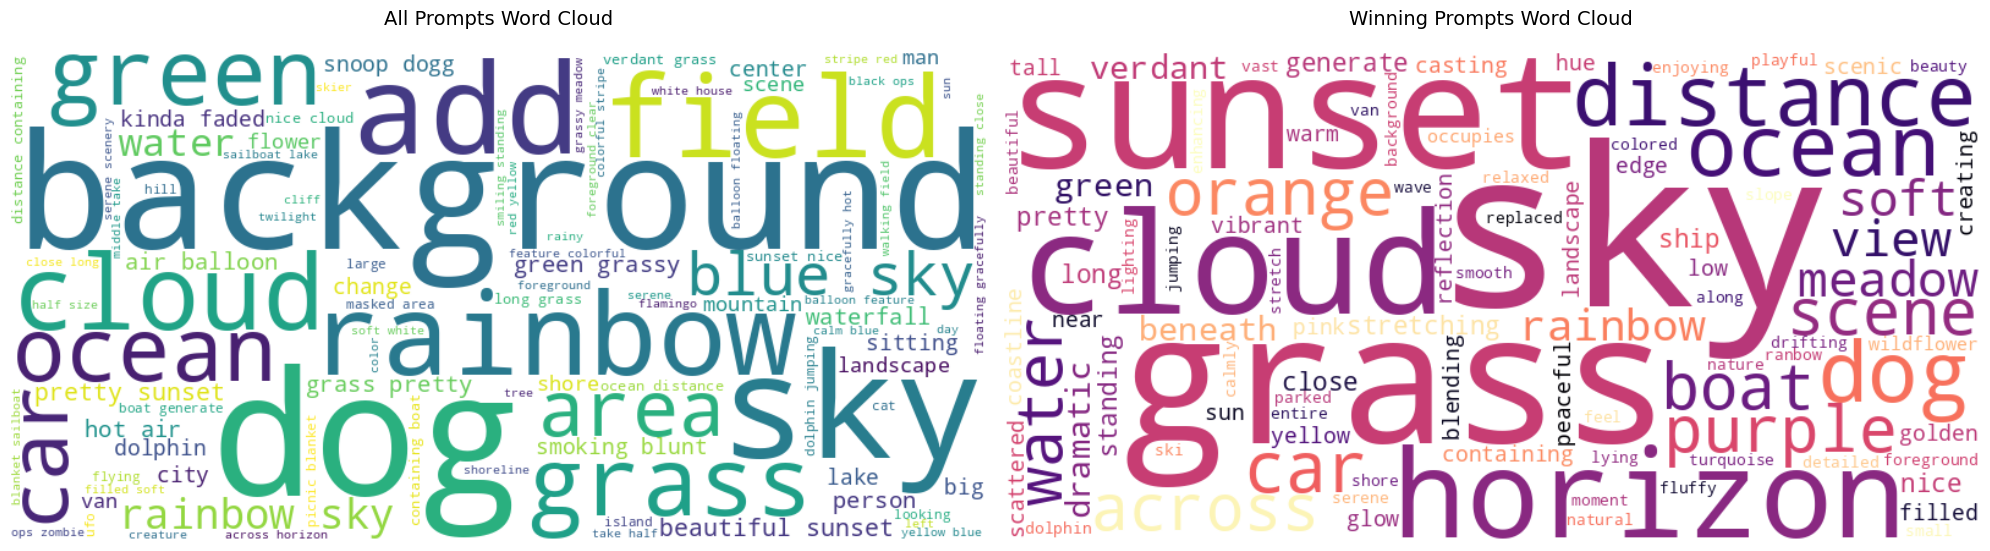

In [ ]:
# Setup Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Word Cloud for All Prompts
all_text = ' '.join(all_prompts['processed_text'])
wordcloud_all = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    colormap='viridis'
).generate(all_text)
ax1.imshow(wordcloud_all, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('All Prompts Word Cloud', pad=20, fontsize=14)

# Word Cloud for Winning Prompts
winning_text = ' '.join(all_prompts[all_prompts['is_winner'] == 1]['processed_text'])
wordcloud_winners = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    colormap='magma'
).generate(winning_text)
ax2.imshow(wordcloud_winners, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Winning Prompts Word Cloud', pad=20, fontsize=14)

plt.tight_layout()
plt.show()

### Word Evolution


Most common words overall:
sky: 52
dog: 42
background: 38
grass: 36
rainbow: 32
cloud: 29
sunset: 25
field: 25
green: 24
add: 22


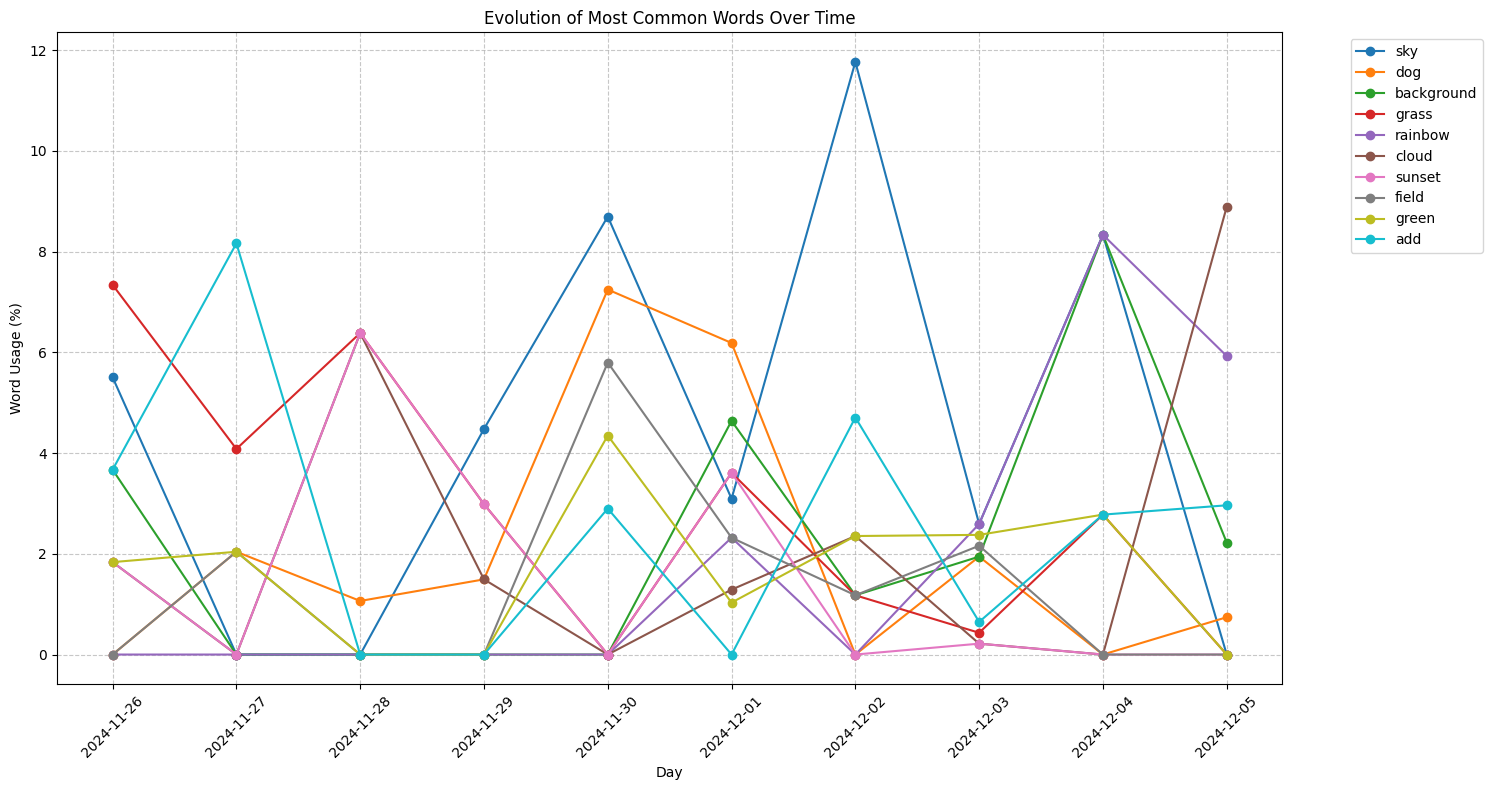

In [ ]:
from collections import Counter

# Get word frequencies by day
daily_words = {}
for day in sorted(all_prompts['day'].unique()):
    day_prompts = all_prompts[all_prompts['day'] == day]['processed_text']
    words = ' '.join(day_prompts).split()
    daily_words[day] = Counter(words)

# Find most common words across all days
all_common_words = Counter(' '.join(all_prompts['processed_text']).split()).most_common(10)
print("\nMost common words overall:")
for word, count in all_common_words:
    print(f"{word}: {count}")

# Track these common words over time
word_evolution = {word: [] for word, _ in all_common_words}
days = sorted(all_prompts['day'].unique())

for day in days:
    day_freq = daily_words[day]
    total_words = sum(day_freq.values())
    for word, _ in all_common_words:
        # Calculate percentage of word usage
        percentage = (day_freq[word] / total_words * 100) if total_words > 0 else 0
        word_evolution[word].append(percentage)

# Plot word evolution
plt.figure(figsize=(15, 8))
for word in word_evolution:
    plt.plot(days, word_evolution[word], marker='o', label=word)

plt.title('Evolution of Most Common Words Over Time')
plt.xlabel('Day')
plt.ylabel('Word Usage (%)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()